In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import glob
import os
import scipy.stats
from matplotlib import cm
import seaborn as sns
import dask
import pickle
from datetime import datetime
import ast

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
models = [x.split('/')[-1] for x in glob.glob("/terra/data/cmip5/global/rcp85/*")]   

In [4]:
dic = {}

In [ ]:
for model in models:
    try:
        rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/tas_*"))
        rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
        rcp85 = rcp85.sel(time = slice('2000','2250'))
        hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/tas_*"))
        hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
        x = xr.concat([hist,rcp85],dim='time').load()
        x = x.sortby(x.time)
        x = x.resample(time='M').mean()
        dic[model] = x - hist.sel(time=slice('1979','2005')).mean(dim='time')
    except:
        print(model)

BNU-ESM
CNRM-CM5
EC-EARTH


In [ ]:
model = 'BNU-ESM' 

# no historical monthly data 

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/tas_*"))
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/day/native/tas_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
hist = hist.resample(time='M').mean()
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - hist.sel(time=slice('1979','2005')).mean(dim='time')

In [ ]:
model = 'MPI-ESM-LR'  

# a problem with the later than 2100 data

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/tas_*"))[0]
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/tas_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [ ]:
model = 'CNRM-CM5'

# a problem with the later than 2100 data

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/tas_*"))[:2]
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/tas_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').tas
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [ ]:
#NOAA
x = xr.open_mfdataset('/home/pmarsh/NOAA_2deg/air.2m.mon.mean.nc', decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').air
x = x.sortby(x.time)
x = x.resample(time='M').mean()
x = x.sel(time=slice('1940','2016'))
dic['NOAA'] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [10]:
#ERA5 - 1hr - daily avalable but missing some data 
x = xr.open_mfdataset(sorted(glob.glob('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/1hr/native/tas_*')), decode_cf=True).sel(latitude = -34, method = 'nearest').sel(longitude = 18, method = 'nearest').tas
x = x.resample(time='M').mean()
x = x.sortby(x.time).load()
dic['ERA5'] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [11]:
for index in dic:
    date_string = str('1/'+str(dic[index].time[0].dt.month.values)+'/'+str(dic[index].time[0].dt.year.values))
    start = datetime.strptime(date_string, "%d/%m/%Y")
    x = pd.date_range(start, periods=len(dic[index].time), freq='M')
    dic[index]['time'] = x

In [12]:
rolled={}
for index in dic:
    rolled[index] = dic[index].load().rolling(time = 120, center = True).mean()

In [13]:
cmip = [model for model in models if model in dic.keys()]

In [39]:
selled = {}
for index in dic:
    selled[index] = rolled[index].sel(time = slice('1979','2080'))

In [40]:
maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in cmip:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
    

cmip_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [41]:
results = pd.read_csv('results.csv').set_index('Model')
results = [model for model in results.index if model in cmip]

maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in results:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
considered_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [42]:
winners = ['MIROC-ESM-CHEM','BNU-ESM','CNRM-CM5','GFDL-ESM2M','bcc-csm1-1','ACCESS1-0']


maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in winners:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
winners_range = xr.Dataset(dict(maximum = (["time"], maximum), minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [43]:
col_dic = pickle.load(open('col_dic.p','rb'))

In [71]:
end = pd.to_datetime('2100/01/01')

In [45]:
""""
end = pd.to_datetime('2100/01/01')
counter = 0 
alpha_offset = 0
for end in pd.date_range(start = '1983', end = '2120' , freq='M'):
    fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)
    ax.plot(selled['ERA5'].sel(time = slice ('1950',end)).time, selled['ERA5'].sel(time = slice ('1950',end)).values, color = '#002D52', alpha = 1 , linewidth = 2.8 , label = 'ERA5 Reanalysis')
    ax.plot(selled['NOAA'].sel(time = slice ('1950',end)).time, selled['NOAA'].sel(time = slice ('1950',end)).values, color = '#04015C' , alpha = 1 , linewidth = 3 , label = 'NOAA 20CR Reanalysis')
    if end < pd.to_datetime('2100/01/01'):
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = 1 , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = 0.5 , linewidth = 2)
    elif end < pd.to_datetime('2101/07/01'):
        if alpha_offset < 1:
            alpha_offset = alpha_offset+ 0.05
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = (1 - alpha_offset) , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = (0.5 - (alpha_offset/2)) , linewidth = 2)
    x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
    x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
    x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')            
    w = ax.axhline(0 , color = '#00ff1e', label = 'Realistic')
    x = ax.axhline(0 , color = '#ffee00', label = 'Bias')
    y = ax.axhline(0 , color = '#ff1100', label = 'Significant Bias')
    z = ax.axhline(0 , color = '#ff00bb', label = 'Unrealistic')
    zz = ax.axhline(0 , color = 'grey',alpha = 0.5, label = 'Not Assessed')
    plt.legend(loc='upper left', facecolor = 'white')
    w.set_visible(False)
    x.set_visible(False)
    y.set_visible(False)
    z.set_visible(False)
    zz.set_visible(False)
    for x in [-1,0,1,2,3,4, 5]:
            ax.axhline(x,color = 'cadetblue', alpha = 0.5)
    if end < pd.to_datetime('2100/01/01'):
        plt.xlim([pd.to_datetime('1980/01/01'), end + pd.DateOffset(months=24)])
    else:
        plt.xlim([pd.to_datetime('1980/01/01'), pd.to_datetime('2100/01/01')])
    counter = counter+1
    ax.set_ylim(-1,6)
    plt.ylabel('Mean Temperature Anomaly (K)')
    plt.title('Temperature Anomaly')
    plt.savefig('tas_Plots/to_gif'+str(counter)+'png')
    plt.close()
    """

'"\ncounter = 0 \nalpha_offset = 0\nfor end in pd.date_range(start = \'1983\', end = \'2120\' , freq=\'M\'):\n    fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)\n    ax.plot(selled[\'ERA5\'].sel(time = slice (\'1950\',end)).time, selled[\'ERA5\'].sel(time = slice (\'1950\',end)).values, color = \'#002D52\', alpha = 1 , linewidth = 2.8 , label = \'ERA5 Reanalysis\')\n    ax.plot(selled[\'NOAA\'].sel(time = slice (\'1950\',end)).time, selled[\'NOAA\'].sel(time = slice (\'1950\',end)).values, color = \'#04015C\' , alpha = 1 , linewidth = 3 , label = \'NOAA 20CR Reanalysis\')\n    if end < pd.to_datetime(\'2100/01/01\'):\n        for model in cmip:\n            if model in col_dic.keys():\n                ax.plot(selled[model].sel(time = slice (\'1950\',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice (\'1950\',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = 1 , linewidth = 4.5)\n            else:\n                ax.plot(selled[model].sel

In [46]:
ls = {}
for index in col_dic:
    if col_dic[index] == '#00ff1e':
        ls[index] = 4
    elif col_dic[index] == '#ffee00':
        ls[index] = 3
    elif col_dic[index] == '#ff1100':
        ls[index] = 2
    elif col_dic[index] == '#ff00bb':
        ls[index] = 1

In [47]:
file = open("../genealogy/Knutti_colours_dict.txt", "r")
contents = file.read()
knutti_dic = ast.literal_eval(contents)
file.close()

Text(0.5, 1.0, 'Temperature Anomaly')

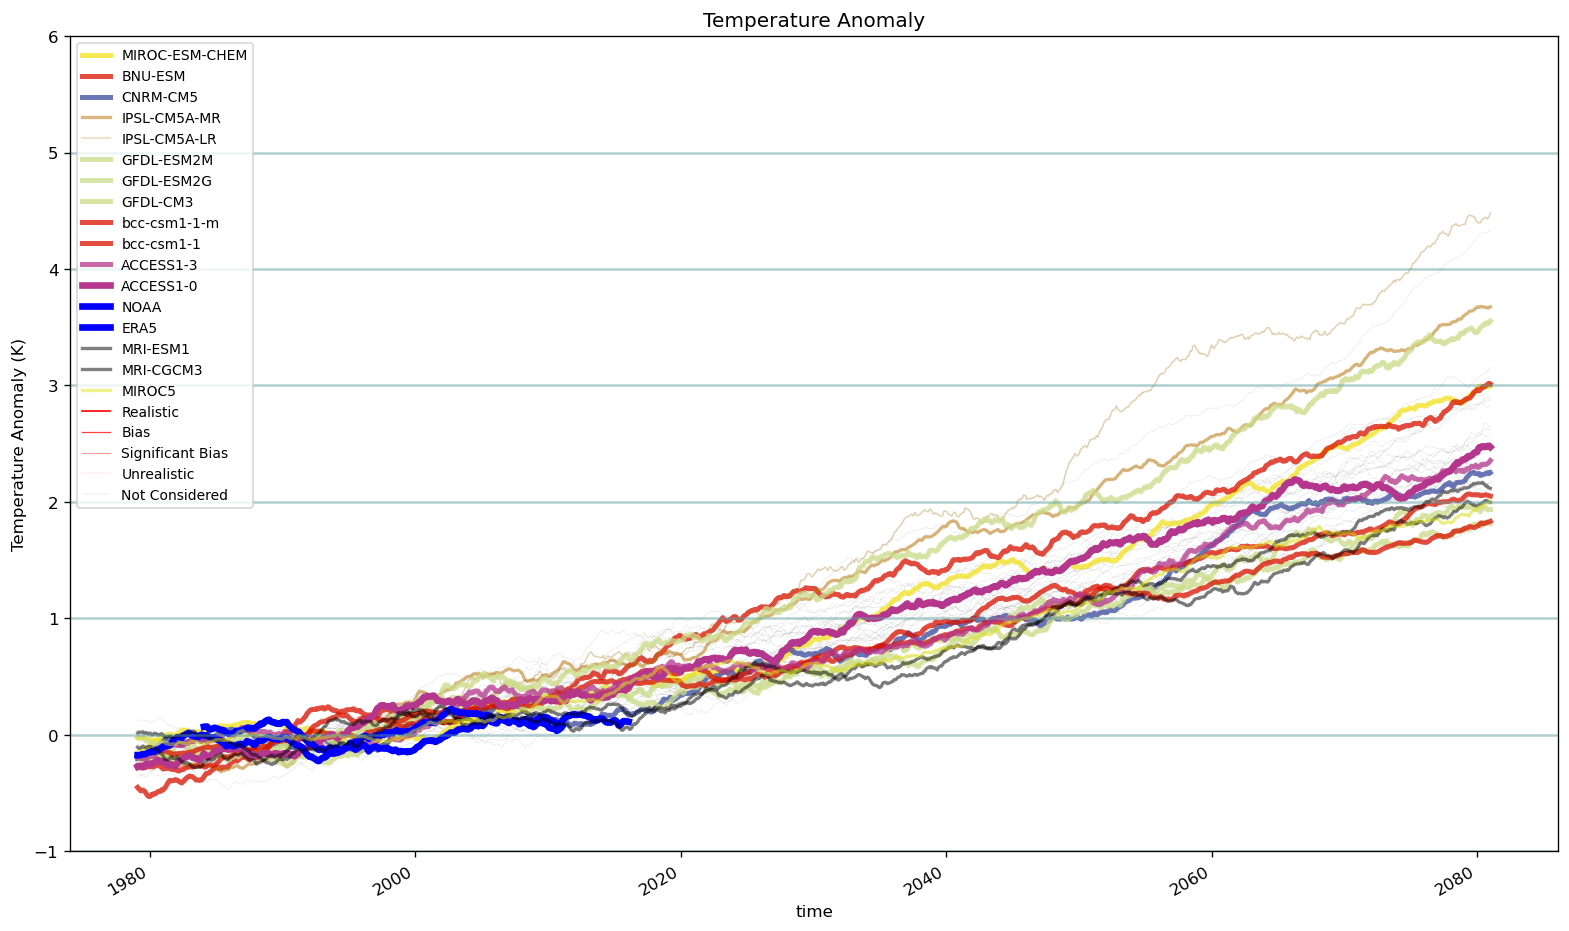

In [48]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 120)



for index in selled:
    selled[index].plot(color = 'black' , linewidth = 0.25, alpha = 0.15)

for win in col_dic:
    selled[win].plot(label = str(win) , color = knutti_dic[win] , linewidth = ls[win], alpha = ls[win]/4)

    
    

x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
#ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble') 


for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)


w = ax.axhline(0 , color = 'red',  alpha = 1, linewidth = 1, label = 'Realistic')
x = ax.axhline(0 ,color = 'red',  alpha = 3/4, linewidth = 3/4,  label = 'Bias')
y = ax.axhline(0 , color = 'red',  alpha = 2/4, linewidth = 2/4,  label = 'Significant Bias')
z = ax.axhline(0 , color = 'red',  alpha = 1/4, linewidth = 1/4, label = 'Unrealistic')

zz = ax.axhline(0 , color = 'black',  alpha = 0.25, linewidth = 0.15, label = 'Not Considered')

plt.legend(loc='upper left', fontsize = 'small')

w.set_visible(False)
x.set_visible(False)
y.set_visible(False)
z.set_visible(False)
zz.set_visible(False)


ax.set_ylim(-1,6)
plt.ylabel('Temperature Anomaly (K)')
plt.title('Temperature Anomaly')
#plt.savefig('tas_family_series.png',dpi=240)
#plt.savefig('tas_family_series.pdf')

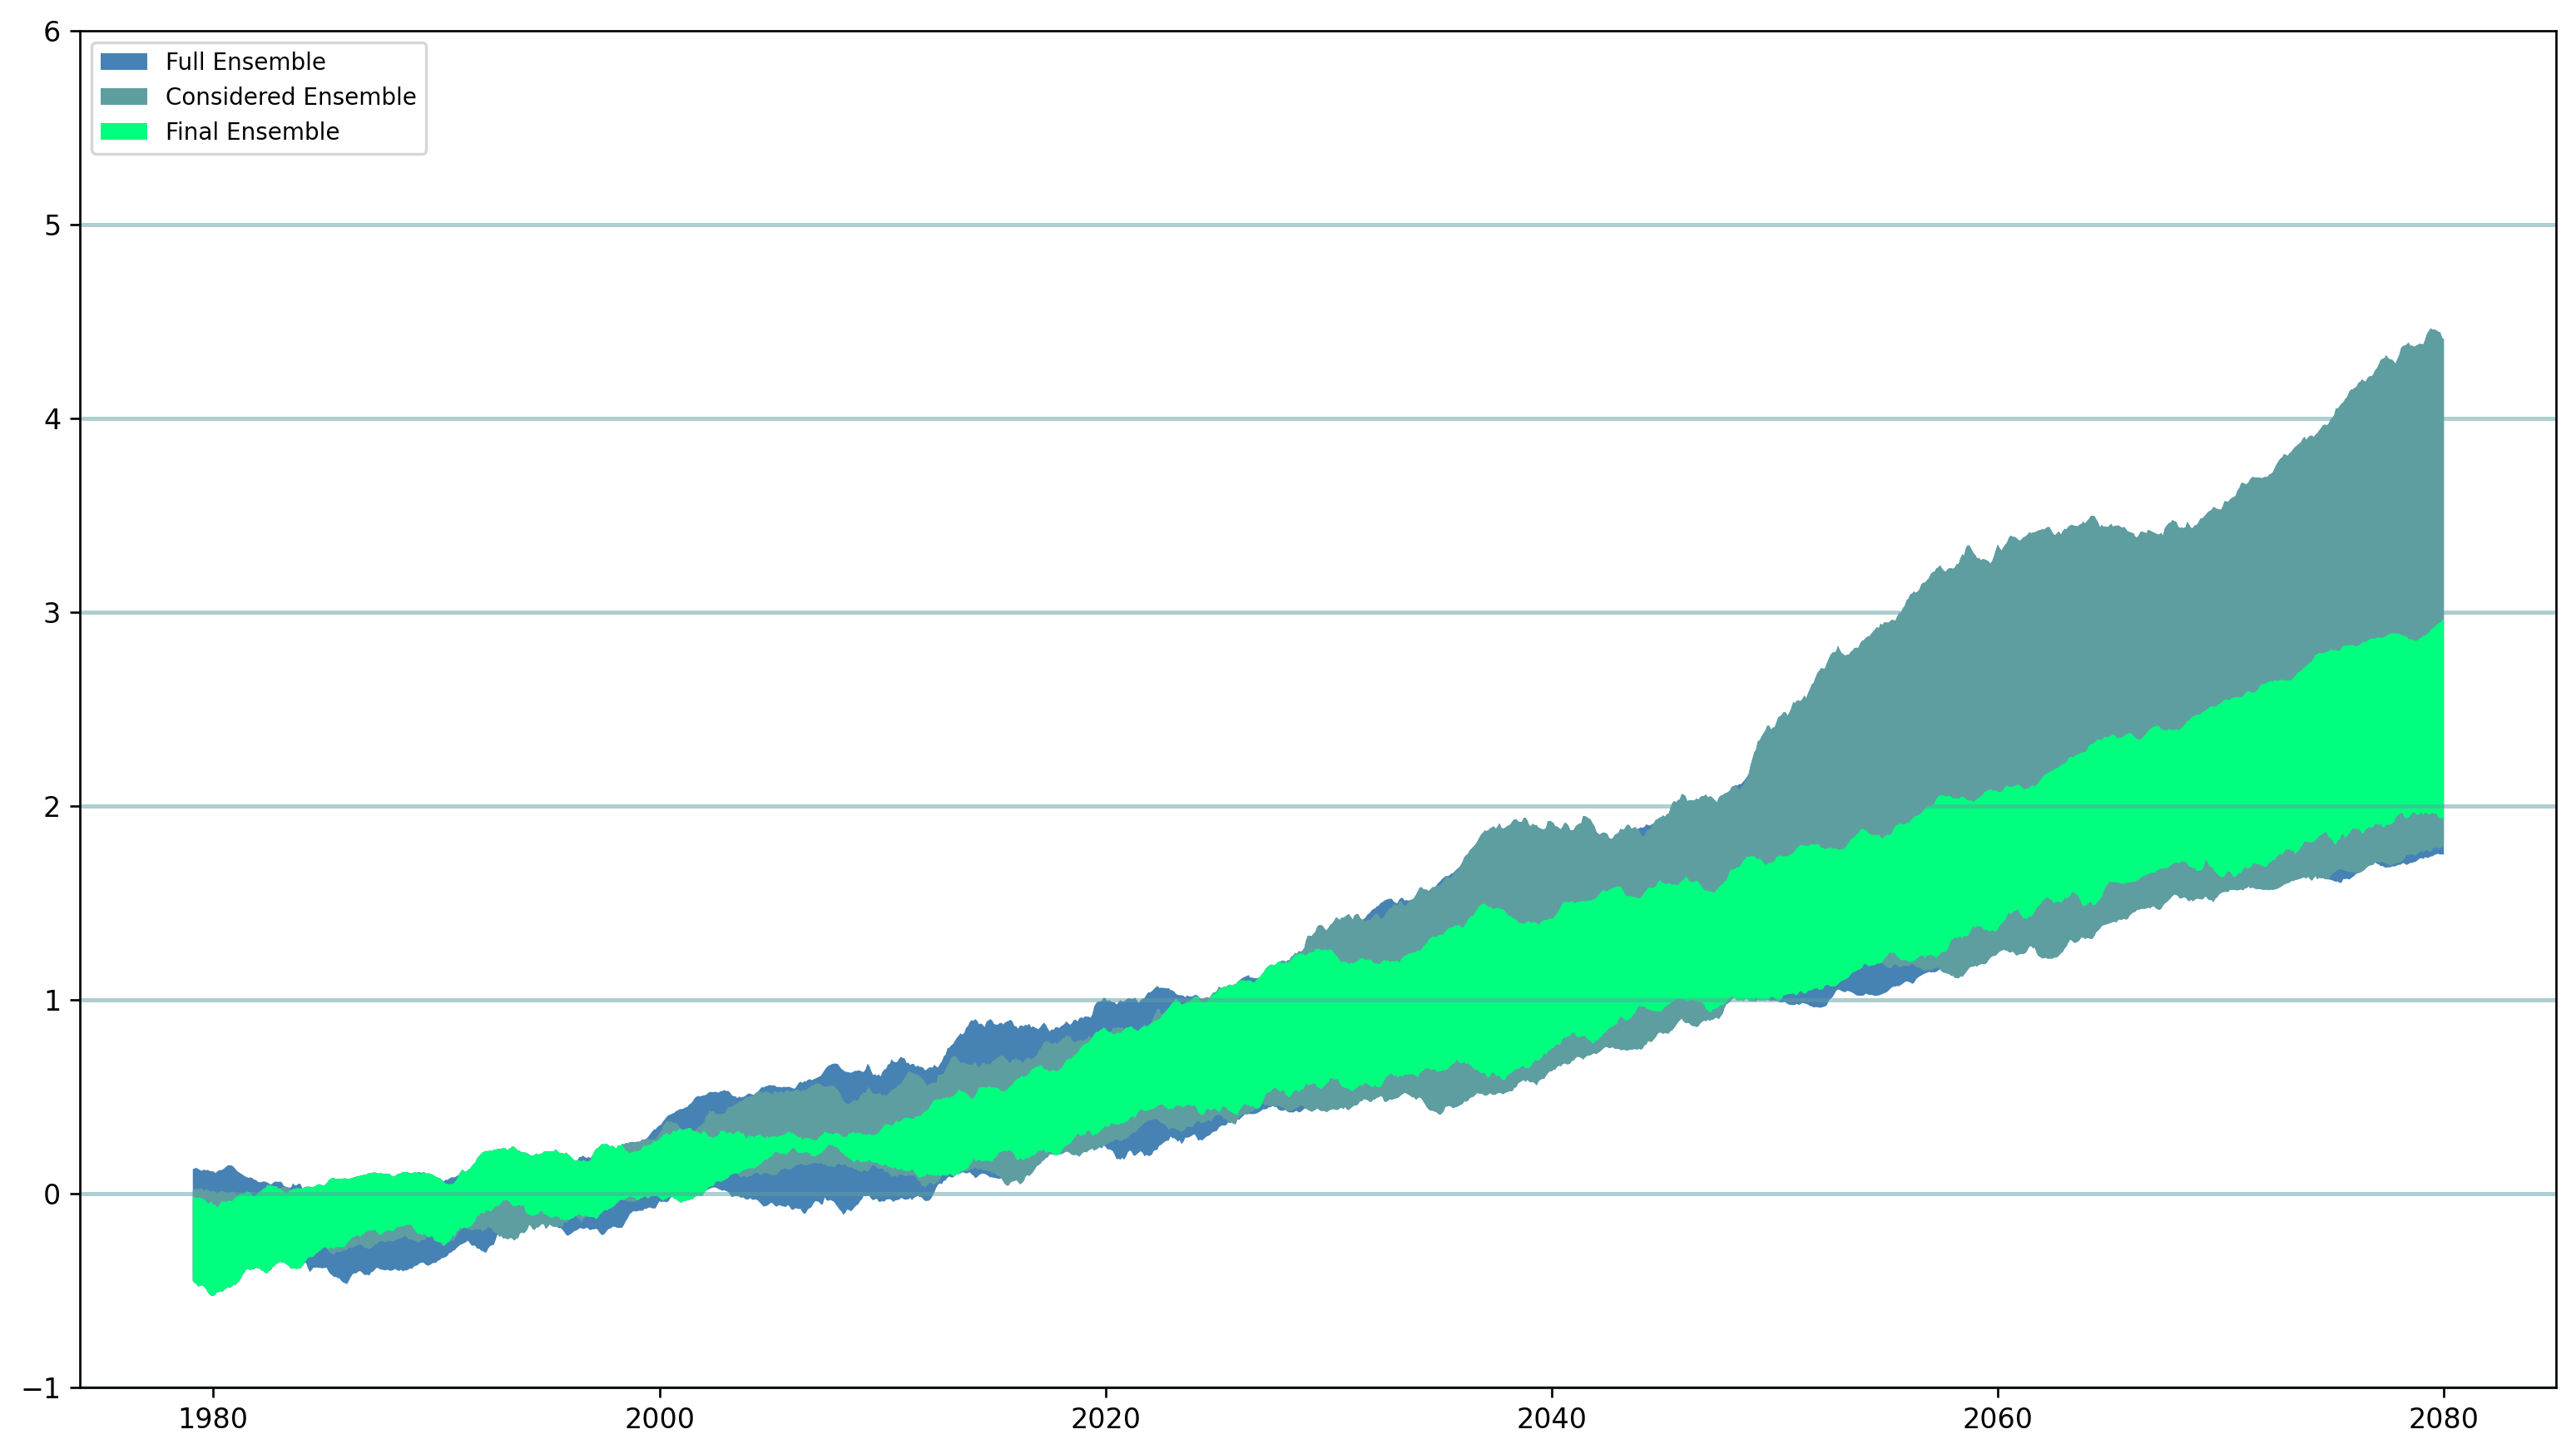

In [49]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)

    
x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')     

for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)




ax.set_ylim(-1,6)

plt.legend(loc='upper left', fontsize = 'small')
#plt.savefig('tas_selected.png',dpi=240)
#plt.savefig('tas_selected.pdf')

In [75]:
end = pd.to_datetime('2080/12/30')

In [51]:
familys = [['MIROC-ESM-CHEM'] , ['BNU-ESM'] , ['CNRM-CM5'] , ['IPSL-CM5A-MR','IPSL-CM5A-LR'] , ['GFDL-ESM2M','GFDL-ESM2G','GFDL-CM3'] , ['bcc-csm1-1-m','bcc-csm1-1'] , ['ACCESS1-0','ACCESS1-3'] , ['MRI-ESM1','MRI-CGCM3'], ['MIROC5']]

In [85]:
for fam in familys:
    fig,ax = plt.subplots(figsize=(16, 9))
    for model in col_dic:
        selled[model].plot(color = col_dic[model] , linewidth = 1.5, alpha = 0.4)
    for model in fam:
        selled[model].plot(label = str(model) , color = col_dic[model] , linewidth = 4.5) 
        ax.annotate(xy=(end,selled[model].dropna(dim='time').values[-1]), xytext=(3,0), textcoords='offset points', text=str(model), va='center',color = 'black')
    x = considered_range
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=0.8, label = 'Considered Ensemble')     
    for x in [-1,0,1,2,3,4, 5]:
        ax.axhline(x,color = 'cadetblue', alpha = 0.5)
    ax.set_ylim(-1,6)
    ax.set_xlim(pd.to_datetime('1970/01/01'), pd.to_datetime('2095/01/01'))
    plt.legend(loc='upper left', fontsize = 'small')
    plt.ylabel('Temperature Anomaly (K)')
    plt.title(str(fam))
    plt.savefig('FAMILY_PLOTS/'+str(fam[0])+'.pdf')
    plt.close()

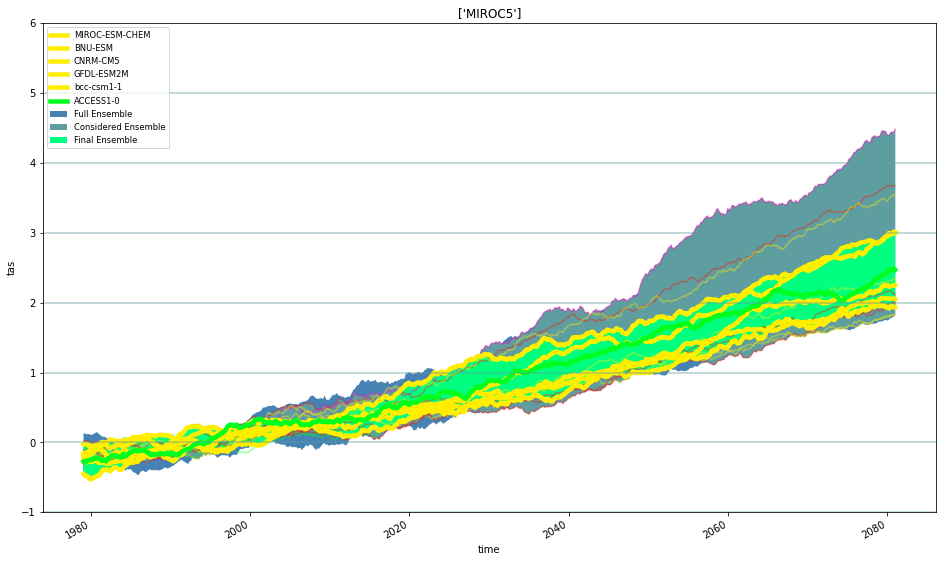

In [53]:
fig,ax = plt.subplots(figsize=(16, 9))
for model in col_dic:
    selled[model].plot(color = col_dic[model] , linewidth = 1.5, alpha = 0.4)
for model in winners:
    selled[model].plot(label = str(model) , color = col_dic[model] , linewidth = 4.5) 
x = cmip_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
x = considered_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')     
for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.set_ylim(-1,6)
plt.legend(loc='upper left', fontsize = 'small')
plt.title(str(fam))
plt.show()

In [115]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

In [154]:
# Make the colormap from the saved image
from matplotlib.image import imread
from matplotlib.colors import LinearSegmentedColormap

img = imread('gistemp_cmap.png')
# just pick one column for the colormap
colors_from_img = img[3, :, :]
giss_cmap = LinearSegmentedColormap.from_list('giss_cmap', colors_from_img, N=254)

In [133]:
PDFs=[]
startDates=[]
def makePDFs(x):
    for i in range(len(x) // 12):
        xx = np.linspace(-5,5,2048) #range to calculate over
        indexMin = 12*i 
        indexMax = 12*(i+1)
        pdf = gaussian_kde(x.values[indexMin:indexMax])
        PDFs.append(pdf(xx))
        startDates.append(x.time.values[indexMin])

makePDFs(dic['NOAA'])

In [147]:
startDates = [pd.to_datetime(x).year for x in startDates]

In [155]:
def GISSfig(plotTime, startDates, PDFs, timeStep=1., ymax = 0.6):
    from matplotlib.ticker import StrMethodFormatter
    plt.style.use('dark_background')
    fig= plt.figure (figsize=(16,9), dpi = 240)
    f,ax=plt.subplots(figsize=(16,9), dpi = 240)
    nPlot = int((plotTime-startDates[0])/timeStep)
    interpFrac = (plotTime-startDates[0])%timeStep
    plot=PDFs[nPlot]*(1-interpFrac) + interpFrac*PDFs[nPlot+1]
    res = giss_cmap((xx+2.)/4.) #This colormap is applied from -2 to 2 degrees in SVS visualizations
    for j in range(len(xx)-1):
        plt.fill_between(xx[j:j+2], np.zeros(2), plot[j:j+2], zorder=2, color=res[j])
    plt.plot(xx,plot,color='w',zorder=4)
    plt.plot(xx,PDFs[0],color="grey",zorder=3)
    plt.ylim(0,ymax)
    plt.xlim(-5,5)
    plt.yticks(ticks=None)
    ax.yaxis.set_visible(False)
    plt.grid(True)
    plt.title("Land Temperature Anomaly Distribution",fontsize=32)
    plt.text(.80, 0.85 , f'{int(plotTime)}', fontsize=24,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    plt.xlabel(u'Temperature Anomaly (°C)', fontsize=14)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

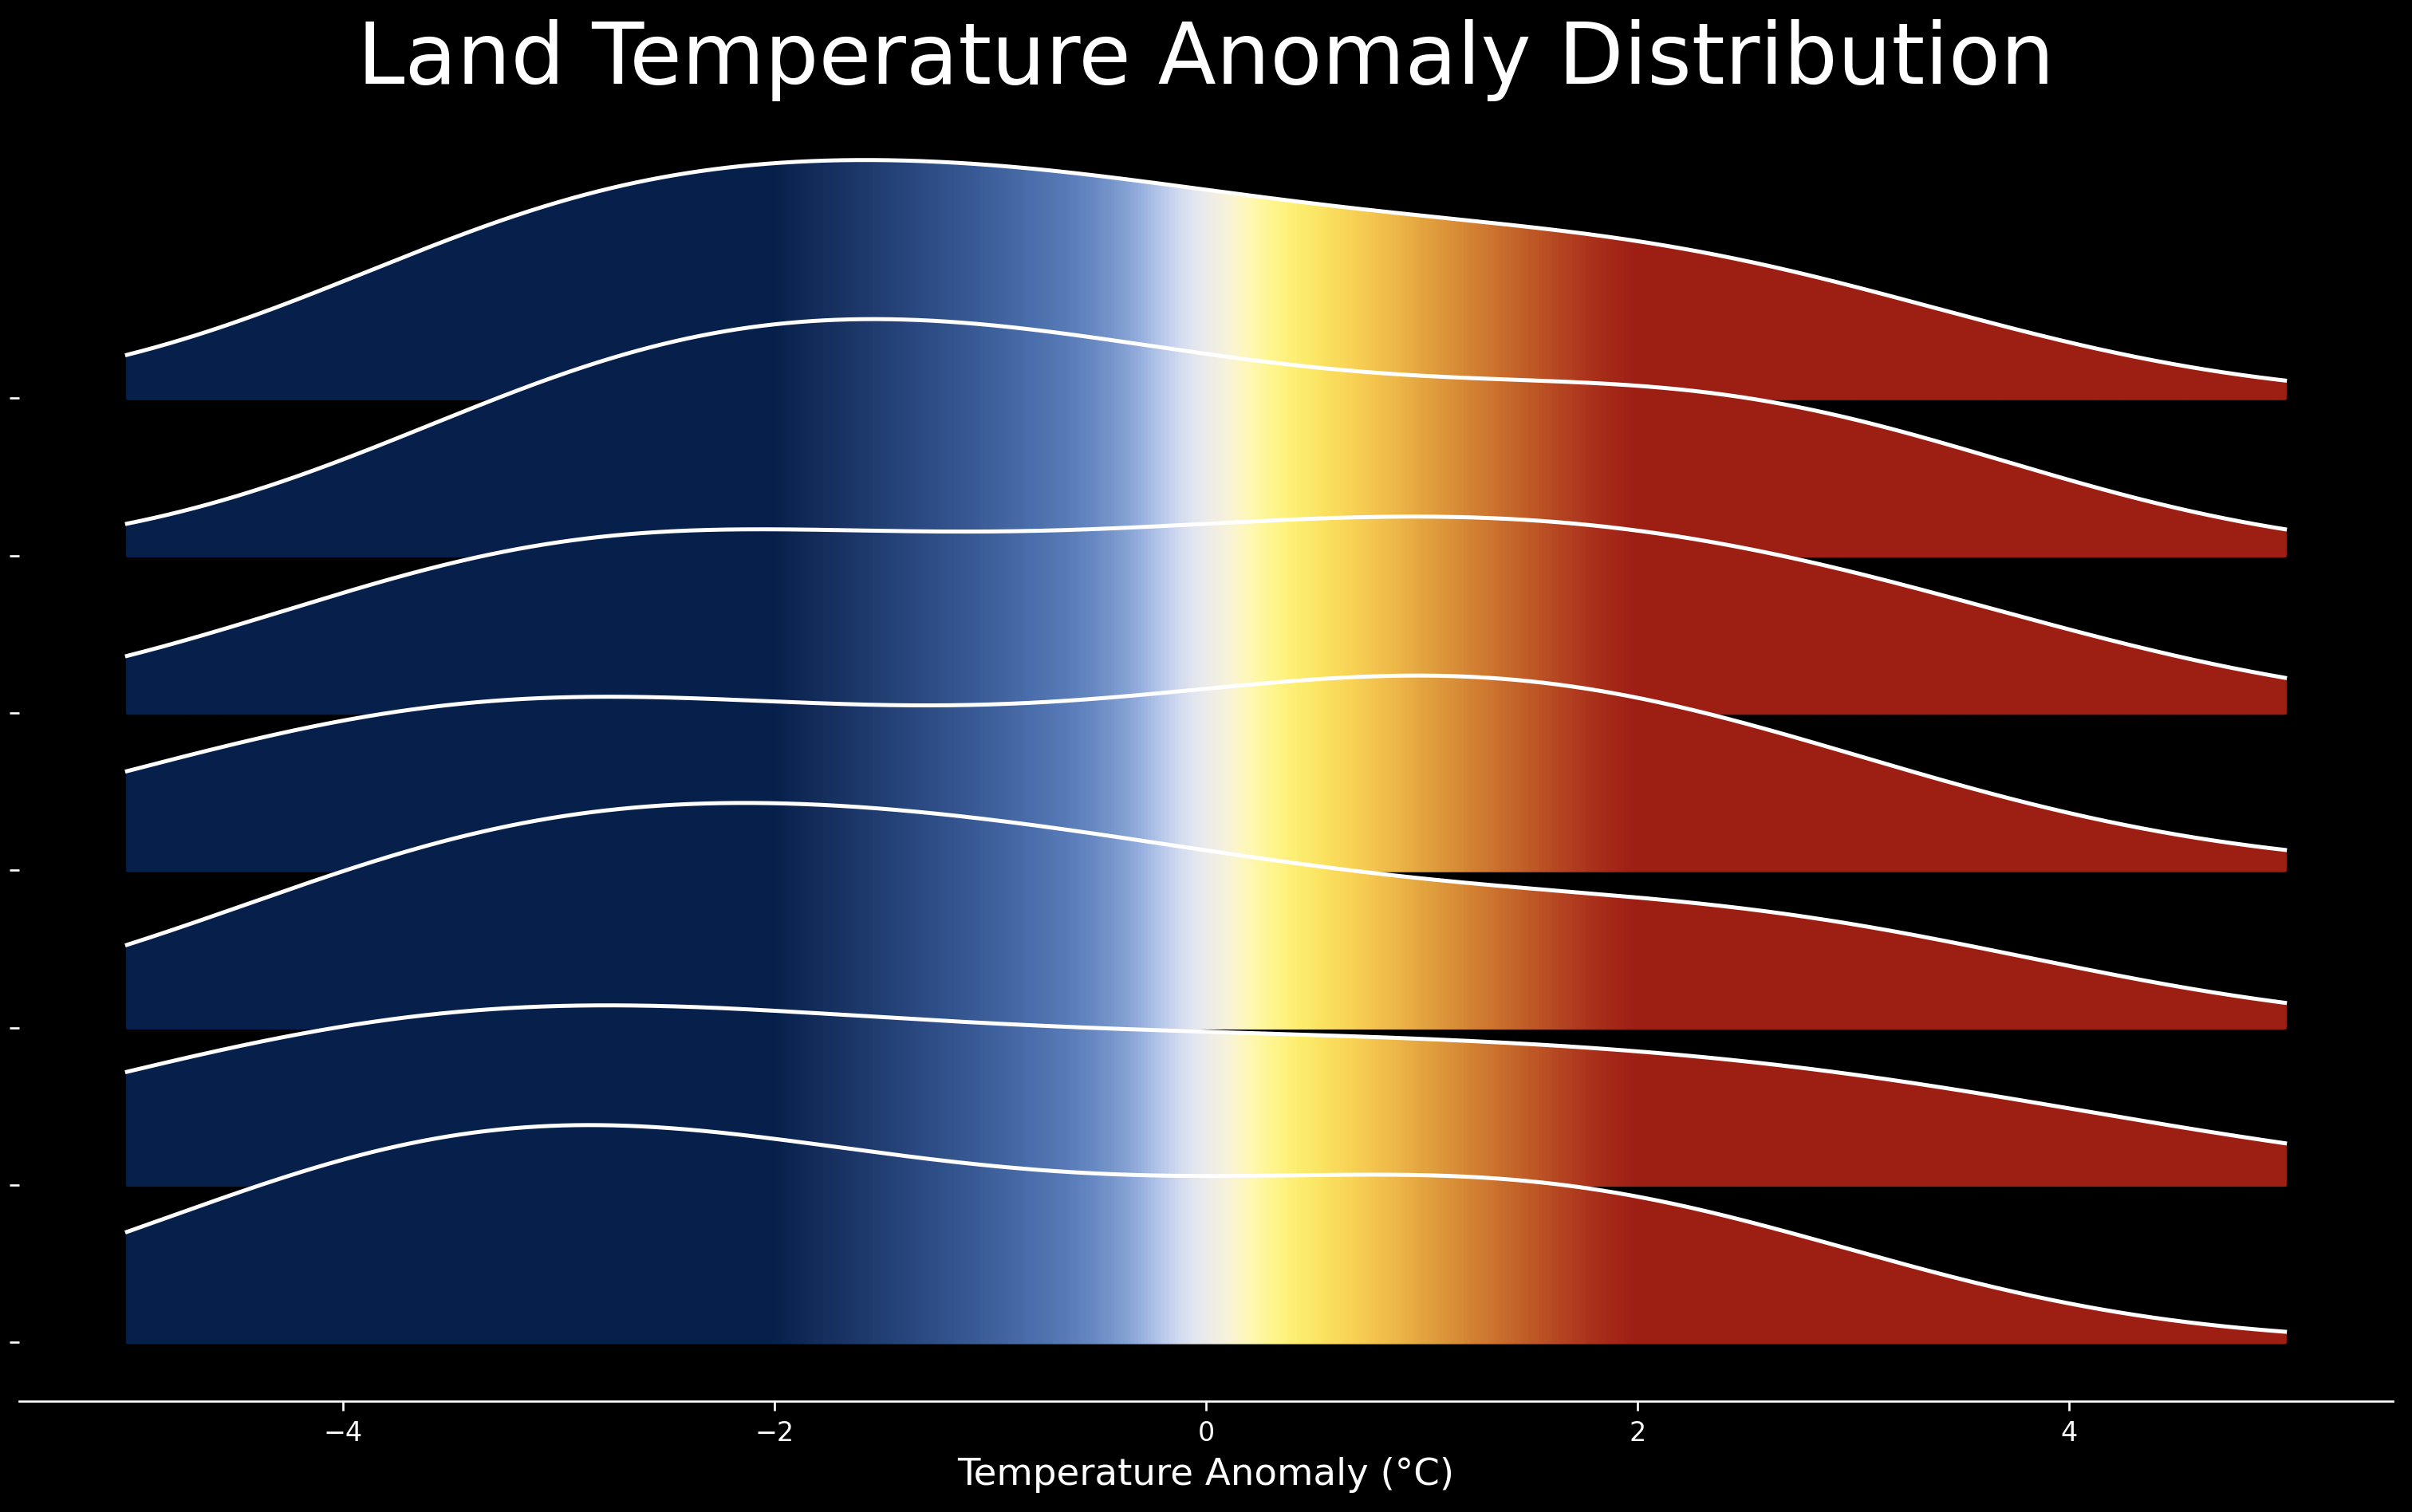

In [174]:
tOffset = 71 # The number of years to skip since the data started in 1880, a value of 71 starts us in 1951
timeStep = 10 # The step between calculated distributions in years
timeBins= 10 # The amount of data to bin in years, usually the same as timeStep
plotRange = (-5.,5.) # The range, in degrees Celcius, over which the PDFs will be calculates
PDFs=[]
startDates=[]
makePDFs(dic['NOAA'])
fig = plt.figure (figsize=(16,9), dpi=240)
nSkip =30 # Amount to skip from the top of the graph (in years)
overlap = 0.9
ys=[]
labels = []
for i in range(7):
    res = giss_cmap((xx+2.)/4.)
    y = 1. - (i-nSkip)*(1.0-overlap)
    ys.append(y)
    for j in range(len(xx)-1):
        plt.fill_between(xx[j:j+2], np.ones(2)*y, PDFs[i][j:j+2]+y, zorder=i+1, color=res[j])
    plt.plot(xx, PDFs[i]+y, c='w', zorder=i+1)
    labels.append(f'{1880 + tOffset + i*timeBins} - {1880 + tOffset + (i+1)*timeBins - 1}')
plt.title("Land Temperature Anomaly Distribution",fontsize=32)
plt.xlabel(u'Temperature Anomaly (°C)', fontsize=14)

plt.yticks(ys, labels, fontsize=14)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
